In [1]:
import cv2
import numpy as np
from matplotlib import pyplot
from matplotlib.patches import Rectangle, Circle
from mtcnn.mtcnn import MTCNN

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

In [2]:
from matplotlib import pyplot
from matplotlib.patches import Rectangle, Circle
from mtcnn.mtcnn import MTCNN
 
# draw an image with detected objects
def draw_image_with_boxes(image, result_list):
	# load the image
	data = image
	# plot the image
	pyplot.imshow(data)
	# get the context for drawing boxes
	ax = pyplot.gca()
	# plot each box
	for result in result_list:
		# get coordinates
		x, y, width, height = result['box']
		# create the shape
		rect = Rectangle((x, y), width, height, fill=False, color='red')
		x, y = result['keypoints']['left_eye']
		cir = Circle((x,y))
		# draw the box
		ax.add_patch(rect)
		ax.add_patch(cir)
	# show the plot
	pyplot.show()


In [3]:
def check(point, shape):
    print(point, shape)
    y, x = point
    if y >= shape[0] or x >= shape[1]:
        return False
    if y < 0 or x < 0:
        return False
    return True

In [4]:
def update_corners(top_left, bottom_right, shape, inc):
    y1, x1 = top_left
    y2, x2 = bottom_right
    print(shape)
    h = shape[0]
    w = shape[1]
    if y1 < 0:
        y1 = 0
        y2 = 2 * inc
    elif y2 >= h:
        y2 = h - 1
        y1 = h - (2 * inc) - 1
    if x1 < 0:
        x1 = 0
        x2 = 2 * inc
    elif x2 >= w:
        x2 = w - 1
        x1 = w - (2 * inc) - 1
    return ((y1, x1), (y2, x2))

In [ ]:
def crop(event, x, y, flags, param):
    inc = 75
    if event == cv2.EVENT_LBUTTONDOWN:
        print(x, y)
        while inc <= 150:
            top_left = y - inc, x - inc
            bottom_right = y + inc, x + inc
            top_left, bottom_right = update_corners(top_left, bottom_right, img.shape, inc)
            print(top_left, bottom_right)
            crop_img = img[top_left[0]:bottom_right[0], top_left[1]:bottom_right[1]]
            print(crop_img.shape)
            cv2.imwrite('save1.jpg', crop_img)
            img1 = pyplot.imread('save1.jpg')
            detector = MTCNN()
            faces = detector.detect_faces(img1)
            print(faces)
            if len(faces) > 0:
                draw_image_with_boxes(img1, faces)
                break
            else:
                inc = inc + 25

162 84
(338, 468, 3)
(9, 87) (159, 237)
(150, 150, 3)
[{'box': [26, 25, 105, 118], 'confidence': 0.9960373044013977, 'keypoints': {'left_eye': (59, 75), 'right_eye': (93, 66), 'nose': (75, 82), 'mouth_left': (64, 112), 'mouth_right': (97, 101)}}]


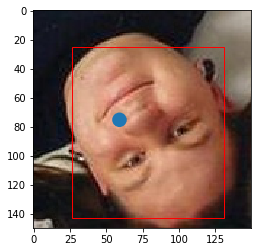

In [ ]:
cv2.namedWindow("image")
img = cv2.imread("Downloads/5.jpg")
cv2.setMouseCallback("image", crop)
cv2.imshow("image", img)
cv2.waitKey(0)
cv2.destroyAllWindows()